<a href="https://colab.research.google.com/github/morales-cmd/TF_MGR_dev/blob/main/music_genre_recognition_show_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing libraries.
import pandas as pd
import tensorflow_datasets as tfds
import os
import librosa
import librosa.display
import numpy as np
import matplotlib as mpl
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from scikitplot.metrics import plot_confusion_matrix, plot_roc
import tensorflow as tf
import gc
import cv2
import math
from google.colab.patches import cv2_imshow
from tensorflow.keras import datasets, layers, models,optimizers, metrics
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import LearningRateScheduler

In [ ]:
# Mounting Google Drive to Colab notebook.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the dataset
Dataset link https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

In [ ]:
# Loading GTZAN audio data.
# NOTE: File named 'jazz.00054.wav' can't be opened by any used software (Colab, VLC, WMP, etc.), so it's been excluded from calculations.
gtzan_audio_files = {}
gtzan_audio_files['blues'] = os.listdir('/content/drive/MyDrive/PZB/GTZAN/Data/genres_original/blues')
gtzan_audio_files['classical'] = os.listdir('/content/drive/MyDrive/PZB/GTZAN/Data/genres_original/classical')
gtzan_audio_files['country'] = os.listdir('/content/drive/MyDrive/PZB/GTZAN/Data/genres_original/country')
gtzan_audio_files['disco'] = os.listdir('/content/drive/MyDrive/PZB/GTZAN/Data/genres_original/disco')
gtzan_audio_files['hiphop'] = os.listdir('/content/drive/MyDrive/PZB/GTZAN/Data/genres_original/hiphop')
gtzan_audio_files['jazz'] = os.listdir('/content/drive/MyDrive/PZB/GTZAN/Data/genres_original/jazz')
gtzan_audio_files['metal'] = os.listdir('/content/drive/MyDrive/PZB/GTZAN/Data/genres_original/metal')
gtzan_audio_files['pop'] = os.listdir('/content/drive/MyDrive/PZB/GTZAN/Data/genres_original/pop')
gtzan_audio_files['reggae'] = os.listdir('/content/drive/MyDrive/PZB/GTZAN/Data/genres_original/reggae')
gtzan_audio_files['rock'] = os.listdir('/content/drive/MyDrive/PZB/GTZAN/Data/genres_original/rock')

print('Audio files:')
for i in gtzan_audio_files:
  print('Genre:', i)
  print(gtzan_audio_files[i])

Audio files:
Genre: blues
['blues.00008.wav', 'blues.00005.wav', 'blues.00000.wav', 'blues.00012.wav', 'blues.00011.wav', 'blues.00001.wav', 'blues.00013.wav', 'blues.00010.wav', 'blues.00007.wav', 'blues.00006.wav', 'blues.00002.wav', 'blues.00009.wav', 'blues.00003.wav', 'blues.00004.wav', 'blues.00014.wav', 'blues.00025.wav', 'blues.00029.wav', 'blues.00031.wav', 'blues.00016.wav', 'blues.00017.wav', 'blues.00028.wav', 'blues.00021.wav', 'blues.00024.wav', 'blues.00027.wav', 'blues.00019.wav', 'blues.00030.wav', 'blues.00022.wav', 'blues.00018.wav', 'blues.00020.wav', 'blues.00033.wav', 'blues.00023.wav', 'blues.00015.wav', 'blues.00026.wav', 'blues.00032.wav', 'blues.00046.wav', 'blues.00034.wav', 'blues.00048.wav', 'blues.00041.wav', 'blues.00043.wav', 'blues.00052.wav', 'blues.00051.wav', 'blues.00035.wav', 'blues.00039.wav', 'blues.00044.wav', 'blues.00040.wav', 'blues.00038.wav', 'blues.00047.wav', 'blues.00045.wav', 'blues.00036.wav', 'blues.00050.wav', 'blues.00049.wav', 'blu

In [ ]:
# Basic statistics regarding GTZAN audio and image data.
gtzan_counters = {}
gtzan_genres = []

for i in gtzan_audio_files:
  gtzan_counters[i] = 0
  gtzan_genres.append(i)
gtzan_counters['all'] = 0

for i in gtzan_audio_files:
  for j in gtzan_audio_files[i]:
    gtzan_counters[i] += 1
    gtzan_counters['all'] += 1

print('Number of GTZAN included genres:', len(gtzan_genres))
print('Included genres:', gtzan_genres, '\n')

print('Number of GTZAN included audio files:', gtzan_counters['all'])
print('Number of included audio files for each genre:')
for i in gtzan_counters:
  if i != 'all':
    print('- ' + str(i) + ': ' + str(gtzan_counters[i]))

Number of GTZAN included genres: 10
Included genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'] 

Number of GTZAN included audio files: 1000
Number of included audio files for each genre:
- blues: 100
- classical: 100
- country: 100
- disco: 100
- hiphop: 100
- jazz: 100
- metal: 100
- pop: 100
- reggae: 100
- rock: 100


Reading audio files, generating spectrograms and normalizing them

In [ ]:
# Analysing GTZAN audio data with Librosa.
data_path = '/content/drive/MyDrive/PZB/GTZAN/Data/genres_original/'

# GTZAN-related variables.
# All values.
gtzan_all_sample_rates = {}
gtzan_all_durations = {}
gtzan_all_channels = {}
# Unique values.
gtzan_unique_sample_rates = {}
gtzan_unique_durations = {}
gtzan_unique_channels = {}
# Sum and mean values.
gtzan_sum_of_durations = 0
gtzan_mean_of_durations = 0
# spectrograms and labels
specs=[]
labels=[]

# Error-related variables.
errors_counter = 0
errors_data = {}

for i in gtzan_audio_files:
  for j in gtzan_audio_files[i]:
    file_path = str(data_path) + str(i) + '/' + str(j)

    try:
      audio_file, sample_rate = librosa.load(file_path, sr = None)
      audio_duration = librosa.get_duration(audio_file, sample_rate)

      gtzan_all_sample_rates[str(j)] = sample_rate
      gtzan_all_durations[str(j)] = audio_duration
      gtzan_all_channels[str(j)] = audio_file.ndim
      gtzan_sum_of_durations += float(gtzan_all_durations[str(j)])
      topdB=80
      melspec = librosa.power_to_db(librosa.feature.melspectrogram(y = audio_file, sr = sample_rate),top_db=topdB, ref = np.max)
      melspec=melspec/-topdB
      specs.append(melspec)
      labels.append(i)
    except Exception as exception:
      print('File', j, 'can\'t be opened.')
      errors_counter += 1
      errors_data[str(j)] = str(exception)

      

  print(i)
      # chroma = librosa.feature.chroma_cqt(y = audio_file, sr = sample_rate)
      # tonnetz = librosa.feature.tonnetz(y = audio_file, sr = sample_rate)

gtzan_mean_of_durations = gtzan_sum_of_durations / int(len(gtzan_all_durations))

blues
classical
country
disco
hiphop


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


File jazz.00054.wav can't be opened.
jazz
metal
pop
reggae
rock


In [ ]:
labels[0]

'blues'

In [ ]:
specs[0]

array([[0.41321597, 0.3517148 , 0.2669417 , ..., 0.52941215, 0.5733109 ,
        0.4572777 ],
       [0.2805031 , 0.16104023, 0.11691909, ..., 0.32203287, 0.38679764,
        0.44493645],
       [0.2102879 , 0.06701465, 0.02629814, ..., 0.25302553, 0.3432344 ,
        0.3478275 ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.87676954],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.8760648 ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.87592447]], dtype=float32)

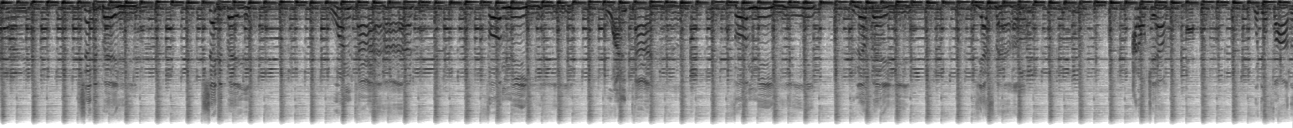

In [ ]:
cv2_imshow(specs[0]*255)

Encoding labels

In [ ]:
le = LabelEncoder()
labels=le.fit_transform(labels)

In [ ]:
le.classes_

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype='<U9')

In [ ]:
# labels=le.inverse_transform(labels)

In [ ]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

Spectrogams resizing

In [ ]:
shapes=[]
for s in specs:
  shapes.append(s.shape)

set(shapes)

{(128, 1290),
 (128, 1292),
 (128, 1293),
 (128, 1296),
 (128, 1297),
 (128, 1298),
 (128, 1299),
 (128, 1300),
 (128, 1301),
 (128, 1302),
 (128, 1303),
 (128, 1304),
 (128, 1305),
 (128, 1307),
 (128, 1308),
 (128, 1309),
 (128, 1310),
 (128, 1313),
 (128, 1314),
 (128, 1320)}

In [ ]:
specs_resized=[]
for s in specs:
  specs_resized.append(cv2.resize(s, (1300,128)))


In [ ]:
shapes=[]
for s in specs_resized:
  shapes.append(s.shape)

set(shapes)

{(128, 1300)}

In [ ]:
specs_resized[0]

array([[0.41321597, 0.35221153, 0.2680829 , ..., 0.5300016 , 0.5723761 ,
        0.4572777 ],
       [0.2805031 , 0.16200513, 0.11751302, ..., 0.32290253, 0.38726604,
        0.44493645],
       [0.2102879 , 0.06817186, 0.02684625, ..., 0.25423685, 0.34327137,
        0.3478275 ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 0.99900717,
        0.87676954],
       [1.        , 1.        , 1.        , ..., 1.        , 0.9990015 ,
        0.8760648 ],
       [1.        , 1.        , 1.        , ..., 1.        , 0.9990004 ,
        0.87592447]], dtype=float32)

# Train - validation split

In [ ]:
#32,30
seed=32
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)

In [ ]:
trainX=[]
trainY=[]
valX=[]
valY=[]
for train_index, test_index in sss.split(specs_resized,labels):
      for ind in train_index:
        trainX.append(specs_resized[ind])
        trainY.append(labels[ind])
      for ind in test_index:
        valX.append(specs_resized[ind])
        valY.append(labels[ind])

In [ ]:
def split_sets_proc(seed):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)
  sss_tr_val=StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)
  trainvalX=[]
  trainvalY=[]
  testX=[]
  testY=[]
  for train_index, test_index in sss.split(specs_resized,labels):
        for ind in train_index:
          trainvalX.append(specs_resized[ind])
          trainvalY.append(labels[ind])
        for ind in test_index:
          testX.append(specs_resized[ind])
          testY.append(labels[ind])
  trainX=[]
  trainY=[]
  valX=[]
  valY=[]
  for train_index, test_index in sss_tr_val.split(trainvalX, trainvalY):
        for ind in train_index:
          trainX.append(trainvalX[ind])
          trainY.append(trainvalY[ind])
        for ind in test_index:
          valX.append(trainvalX[ind])
          valY.append(trainvalY[ind])
  cut_parts=15
  trainX, trainY= cut_specs(trainX,trainY,cut_parts)
  valX, valY= cut_specs(valX,valY,cut_parts)
  testX, testY= cut_specs(testX,testY,cut_parts)
  inp_shape=(trainX[0].shape[0],trainX[0].shape[1],1)

In [ ]:
len(trainX)

899

In [ ]:
len(valX)

100

# Histograms

In [ ]:
colors=['red','tan','lime','yellow','lightcoral','blueviolet','olive','slategrey','gold','cyan']
dist_labels=le.classes_

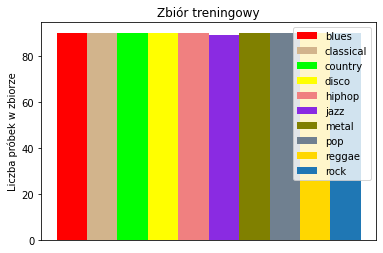

In [ ]:
# plt.hist(trainY)
N, bins, patches=plt.hist(trainY)
for i in range(0,9):
    patches[i].set_facecolor(colors[i])
plt.legend(patches,dist_labels)
plt.xticks([])
plt.title("Zbiór treningowy")
plt.ylabel("Liczba próbek w zbiorze")
plt.show()

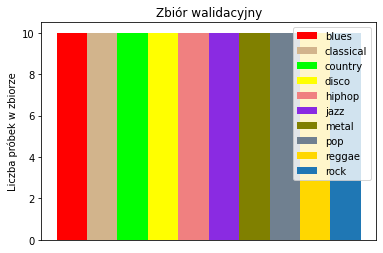

In [ ]:
N, bins, patches=plt.hist(valY)
for i in range(0,9):
    patches[i].set_facecolor(colors[i])
plt.legend(patches,dist_labels)
plt.xticks([])
plt.title("Zbiór walidacyjny")
plt.ylabel("Liczba próbek w zbiorze")
plt.show()

In [ ]:
len(trainY)

899

In [ ]:
len(valY)

100

# Cutting spectrograms (data augmentation)

In [ ]:
def cut_specs(specs,labels,pieces):
  new_specs=[]
  new_labels=[]
  for count, melspec in enumerate(specs):
    sh=melspec.shape
    d=math.floor(sh[1]/pieces)
    for par in range(0,pieces):
      new_specs.append(melspec[0:sh[0], par*d:(par+1)*d])
      new_labels.append(labels[count])
  return new_specs,new_labels

In [ ]:
cut_parts=15
trainX, trainY= cut_specs(trainX,trainY,cut_parts)
valX, valY= cut_specs(valX,valY,cut_parts)


In [ ]:
shapes=[]
for s in trainX:
  shapes.append(s.shape)

set(shapes)

{(128, 86)}

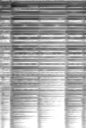

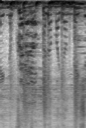

In [ ]:
cv2_imshow(trainX[0]*255)
cv2_imshow(trainX[60]*255)

In [ ]:
inp_shape=(trainX[0].shape[0],trainX[0].shape[1],1)

In [ ]:
inp_shape

(128, 86, 1)

# First model

In [ ]:
try:
  K.clear_session()
  del model
except:
  pass

decaying learning rate

In [ ]:
def lr_scheduler(epoch, lr):
    decay_rate=0.85
    decay_step = 2
    if epoch % decay_step == 0 and epoch:
      # return lr /2
      return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [ ]:
conv_units=48
dense_units=256
dropout=0.2
model = models.Sequential()
model.add(layers.Conv2D(conv_units, (3,3), activation='relu', input_shape=inp_shape))
model.add(layers.MaxPooling2D((2,1)))
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.Conv2D(conv_units*2, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.Conv2D(conv_units*2, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.Conv2D(conv_units*4, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization(axis=-1))

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(dense_units, activation = 'relu'))
model.add(layers.Dropout(rate=dropout))
model.add(layers.Dense(dense_units, activation = 'relu'))
model.add(layers.Dropout(rate=dropout))
model.add(layers.Dense(dense_units, activation = 'relu'))
model.add(layers.Dropout(rate=dropout))
model.add(layers.Dense(10, activation = 'softmax'))

model overview

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 84, 48)       480       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 84, 48)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 84, 48)       192       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 84, 96)        41568     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 42, 96)       0         
 2D)                                                             
                                                        

checkpoint callback

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
opt = optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(np.array(trainX), np.array(trainY), epochs=25, 
                    validation_data=(np.array(valX), np.array(valY)),callbacks=[model_checkpoint_callback,LearningRateScheduler(lr_scheduler, verbose=1)])


Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 1/25
422/422 [==============================] - 27s 36ms/step - loss: 1.5742 - accuracy: 0.4648 - val_loss: 6.3292 - val_accuracy: 0.1013 - lr: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 2/25
422/422 [==============================] - 14s 33ms/step - loss: 0.9697 - accuracy: 0.6747 - val_loss: 1.5486 - val_accuracy: 0.5313 - lr: 5.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0004250000201864168.
Epoch 3/25
422/422 [==============================] - 14s 34ms/step - loss: 0.6167 - accuracy: 0.7943 - val_loss: 0.7902 - val_accuracy: 0.7280 - lr: 4.2500e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00042500003473833203.
Epoch 4/25
422/422 [==============================] - 14s 33ms/step - loss: 0.4540 - accuracy: 0.8511 - val_loss: 0.8499 - val_accuracy: 0.7267 - lr: 4.2500e-04

Epoch 5: LearningRateScheduler set

In [ ]:
model.load_weights(checkpoint_filepath)

training history curves

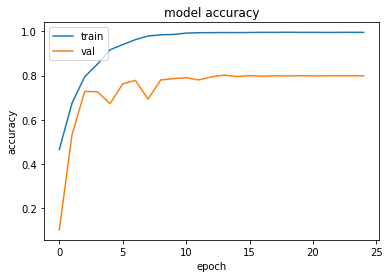

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

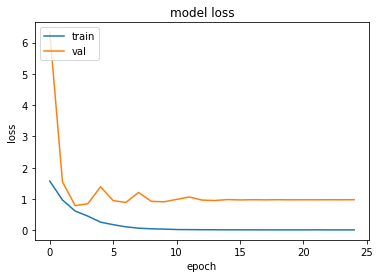

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

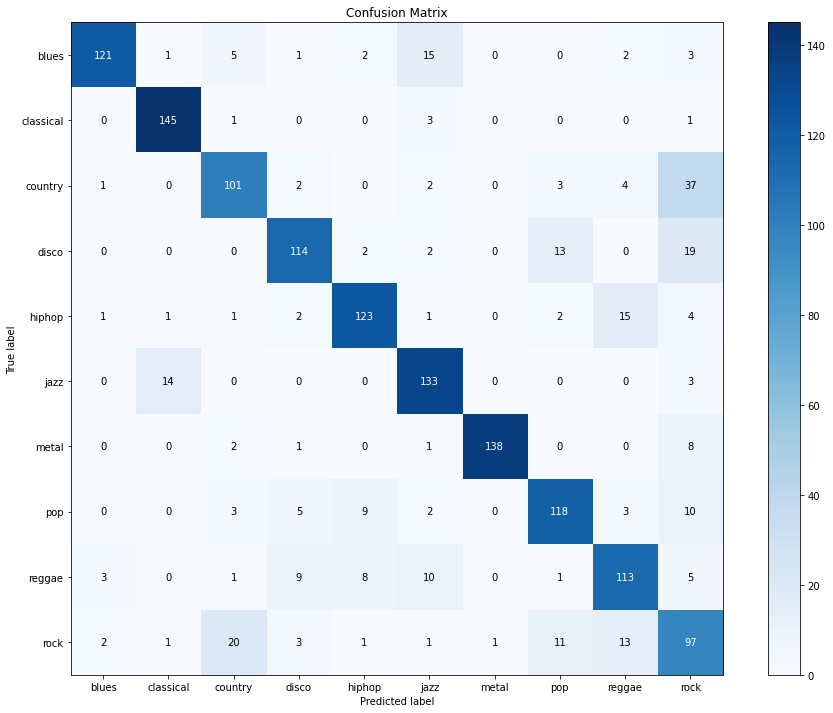

In [ ]:
preds=np.asarray(model.predict(np.array(valX)))
y_pred_class = np.argmax(preds, axis=1)
fig, ax = plt.subplots(figsize=(16,12))
plot_confusion_matrix(le.inverse_transform(np.array(valY)), le.inverse_transform(y_pred_class), ax=ax)


In [ ]:
test_loss, test_acc = model.evaluate(np.array(valX),  np.array(valY), verbose=2)

47/47 - 1s - loss: 0.9521 - accuracy: 0.8020 - 1s/epoch - 23ms/step


saving the model

In [ ]:
model.save('/content/drive/MyDrive/music_genre_rec_model_lite')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/music_genre_rec_model_lite/assets


In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/music_genre_rec_model_lite')

literature comparison 
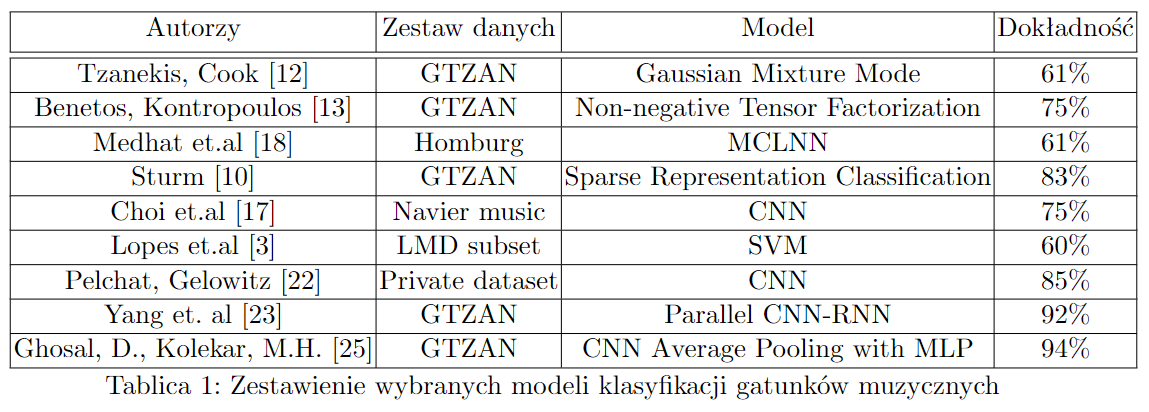
<!-- [10] 83% Sturm nie izoluje zbioru testowego, a wyniki ewaluuje przez uśrednienie wyników walidacji krzyżowej 10-zakładkowej 
[13] 75% Osiągnięta dokłądność przy podziale 90% - 10%
Obaj autorzy nie mówią jasno z jakich danych korzystali dostrajając klasyfikatory -->

# Tests of manually tuned model

In [ ]:
def lr_scheduler(epoch, lr):
    decay_step = 4
    if epoch % decay_step == 0 and epoch:
      return lr /2
    return lr

In [ ]:
def split_sets_proc(seed):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)
  trainX=[]
  trainY=[]
  valX=[]
  valY=[]
  for train_index, test_index in sss.split(specs_resized,labels):
      for ind in train_index:
        trainX.append(specs_resized[ind])
        trainY.append(labels[ind])
      for ind in test_index:
        valX.append(specs_resized[ind])
        valY.append(labels[ind])
  cut_parts=15
  trainX, trainY= cut_specs(trainX,trainY,cut_parts)
  valX, valY= cut_specs(valX,valY,cut_parts)
  inp_shape=(trainX[0].shape[0],trainX[0].shape[1],1)
  return trainX, trainY, valX, valY

In [ ]:
def build_mod():
  conv_units=32
  dense_units=512
  dropuout=0.3
  l_r=0.001
  model = models.Sequential()
  model.add(layers.Conv2D(conv_units, (3,3), activation='relu', input_shape=inp_shape))
  model.add(layers.MaxPooling2D((2,1)))
  model.add(layers.BatchNormalization(axis=-1))
  model.add(layers.Conv2D(conv_units, (3,3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.BatchNormalization(axis=-1))
  model.add(layers.Conv2D(conv_units*2, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.BatchNormalization(axis=-1))
  model.add(layers.Conv2D(conv_units*4, (3,3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.BatchNormalization(axis=-1))

  model.add(layers.Flatten())
  model.add(layers.Dense(dense_units, activation = 'relu'))
  model.add(layers.Dropout(rate=dropuout))
  model.add(layers.Dense(dense_units/2, activation = 'relu'))
  model.add(layers.Dropout(rate=dropuout))
  model.add(layers.Dense(dense_units/4, activation = 'relu'))
  model.add(layers.Dropout(rate=dropuout))
  model.add(layers.Dense(10, activation = 'softmax'))
  opt = optimizers.Adam(learning_rate=l_r)
  model.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
  return model

In [ ]:
def test_procedure(repeats):
  
  epochs_num=25
  res_array=[]
  for i in range (repeats):
    trainX, trainY, valX, valY = split_sets_proc(i+30)
    model=build_mod()
    checkpoint_filepath = '/tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

    LearningRateScheduler(lr_scheduler, verbose=1)
    # stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    history = model.fit(np.array(trainX), np.array(trainY), epochs=epochs_num, 
                        validation_data=(np.array(valX), np.array(valY)),callbacks=[ model_checkpoint_callback, LearningRateScheduler(lr_scheduler, verbose=1)],verbose=2)
    model.load_weights(checkpoint_filepath)
    test_loss, test_acc = model.evaluate(np.array(valX),  np.array(valY), verbose=2)
    res_array.append(test_acc)

    
    plt.figure(i)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    

    plt.figure(i+repeats)
    preds=np.asarray(model.predict(np.array(valX)))
    y_pred_class = np.argmax(preds, axis=1)
    fig, ax = plt.subplots(figsize=(16,12))
    plot_confusion_matrix(le.inverse_transform(np.array(valY)), le.inverse_transform(y_pred_class), ax=ax)
    plt.show()
    
    K.clear_session()
    del model

  return res_array

In [ ]:
model=build_mod()
model.summary()
K.clear_session()
del model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 84, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 84, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 84, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 84, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 42, 32)       0         
 2D)                                                             
                                                        


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/25
422/422 - 8s - loss: 1.8216 - accuracy: 0.3792 - val_loss: 2.7908 - val_accuracy: 0.1773 - lr: 0.0010 - 8s/epoch - 20ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/25
422/422 - 7s - loss: 1.2065 - accuracy: 0.5942 - val_loss: 1.3177 - val_accuracy: 0.5807 - lr: 0.0010 - 7s/epoch - 16ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/25
422/422 - 7s - loss: 0.9005 - accuracy: 0.7030 - val_loss: 1.3512 - val_accuracy: 0.6040 - lr: 0.0010 - 7s/epoch - 17ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/25
422/422 - 7s - loss: 0.7072 - accuracy: 0.7709 - val_loss: 1.0164 - val_accuracy: 0.7080 - lr: 0.0010 - 7s/epoch - 16ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 5/25
422/422 - 7s - loss: 0.4370 - accuracy: 0.859

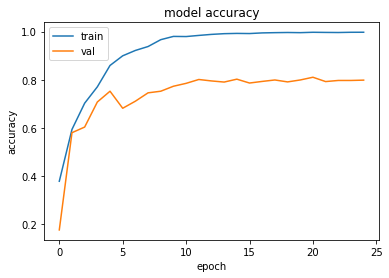

<Figure size 432x288 with 0 Axes>

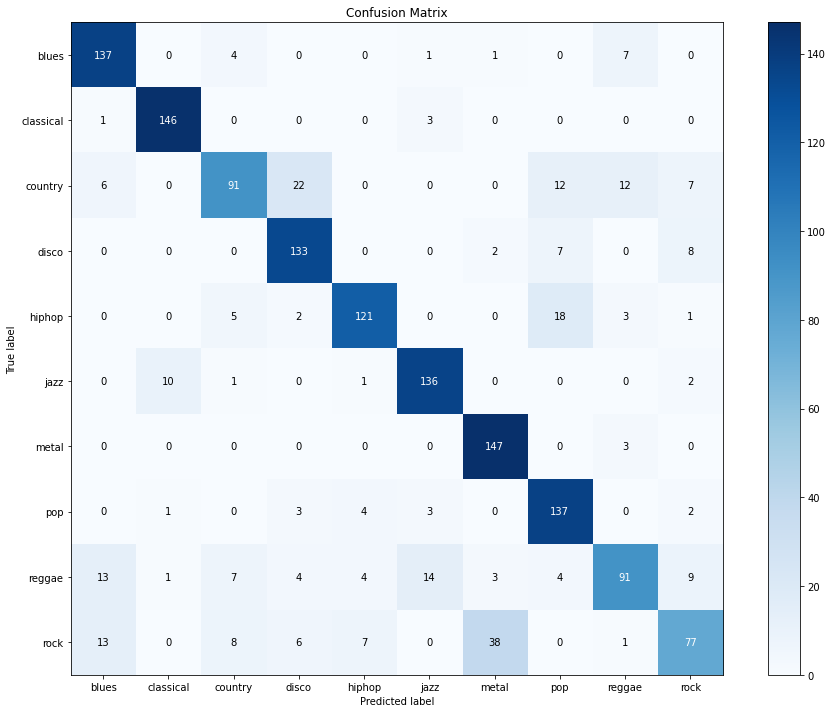


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/25
422/422 - 8s - loss: 1.8070 - accuracy: 0.3834 - val_loss: 2.7218 - val_accuracy: 0.1367 - lr: 0.0010 - 8s/epoch - 19ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/25
422/422 - 7s - loss: 1.1930 - accuracy: 0.5863 - val_loss: 1.2621 - val_accuracy: 0.6127 - lr: 0.0010 - 7s/epoch - 18ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/25
422/422 - 7s - loss: 0.8841 - accuracy: 0.7040 - val_loss: 1.3842 - val_accuracy: 0.5787 - lr: 0.0010 - 7s/epoch - 16ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/25
422/422 - 7s - loss: 0.6929 - accuracy: 0.7735 - val_loss: 1.3168 - val_accuracy: 0.6333 - lr: 0.0010 - 7s/epoch - 17ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 5/25
422/422 - 7s - loss: 0.4385 - accuracy: 0.857

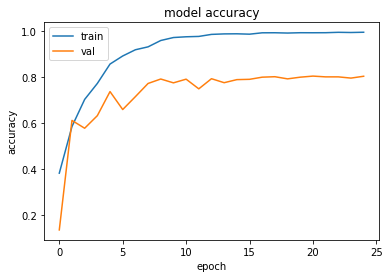

<Figure size 432x288 with 0 Axes>

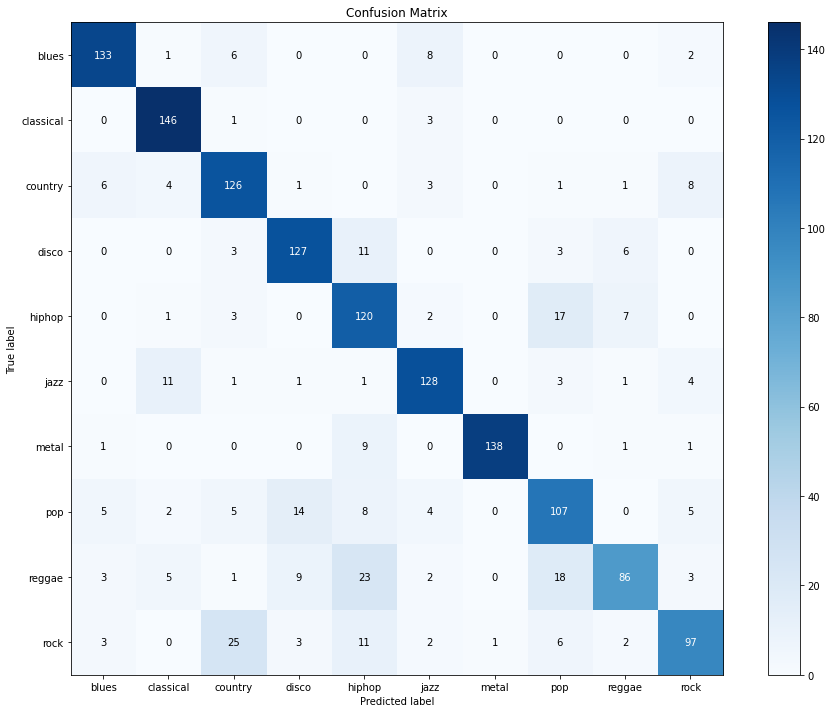


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/25
422/422 - 8s - loss: 1.8079 - accuracy: 0.3761 - val_loss: 3.2578 - val_accuracy: 0.1000 - lr: 0.0010 - 8s/epoch - 20ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/25
422/422 - 7s - loss: 1.1707 - accuracy: 0.6044 - val_loss: 2.1610 - val_accuracy: 0.3473 - lr: 0.0010 - 7s/epoch - 17ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/25
422/422 - 7s - loss: 0.8500 - accuracy: 0.7214 - val_loss: 0.8806 - val_accuracy: 0.7080 - lr: 0.0010 - 7s/epoch - 17ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/25
422/422 - 7s - loss: 0.6325 - accuracy: 0.7992 - val_loss: 2.1471 - val_accuracy: 0.4467 - lr: 0.0010 - 7s/epoch - 17ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 5/25
422/422 - 7s - loss: 0.3837 - accuracy: 0.879

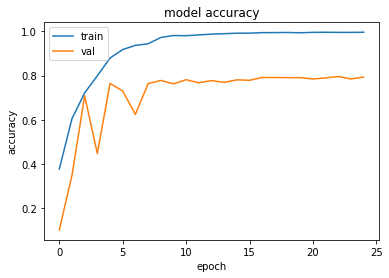

<Figure size 432x288 with 0 Axes>

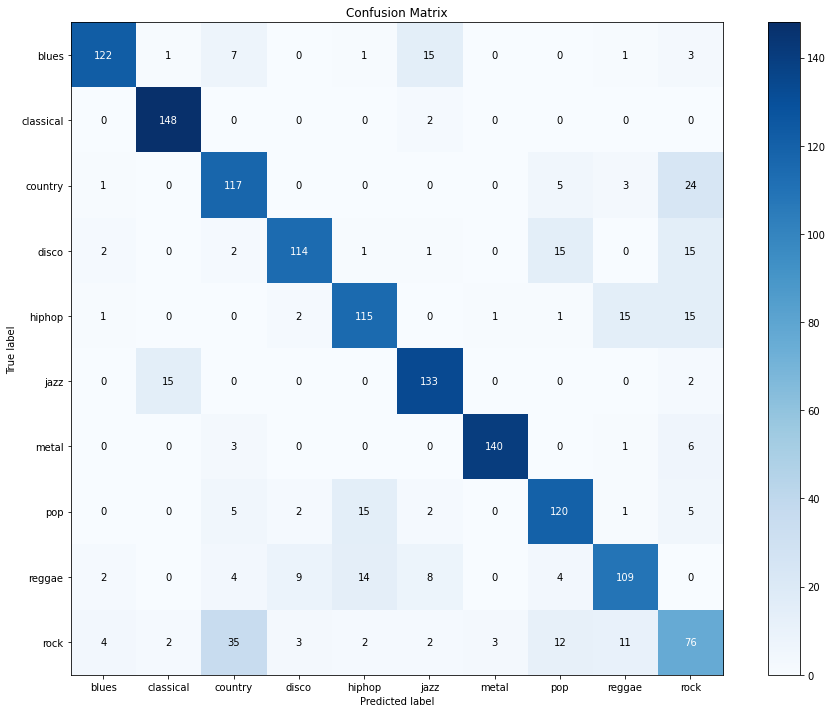


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/25
422/422 - 9s - loss: 1.8236 - accuracy: 0.3743 - val_loss: 2.2960 - val_accuracy: 0.2180 - lr: 0.0010 - 9s/epoch - 21ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/25
422/422 - 7s - loss: 1.1828 - accuracy: 0.5967 - val_loss: 1.0016 - val_accuracy: 0.6633 - lr: 0.0010 - 7s/epoch - 17ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/25
422/422 - 7s - loss: 0.8786 - accuracy: 0.7128 - val_loss: 0.9467 - val_accuracy: 0.6840 - lr: 0.0010 - 7s/epoch - 17ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/25
422/422 - 7s - loss: 0.6933 - accuracy: 0.7801 - val_loss: 1.2801 - val_accuracy: 0.6167 - lr: 0.0010 - 7s/epoch - 16ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 5/25
422/422 - 7s - loss: 0.4174 - accuracy: 0.865

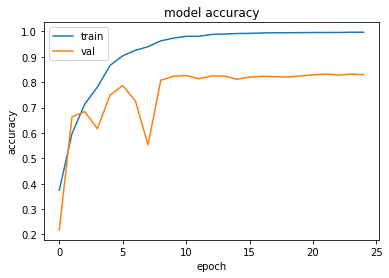

<Figure size 432x288 with 0 Axes>

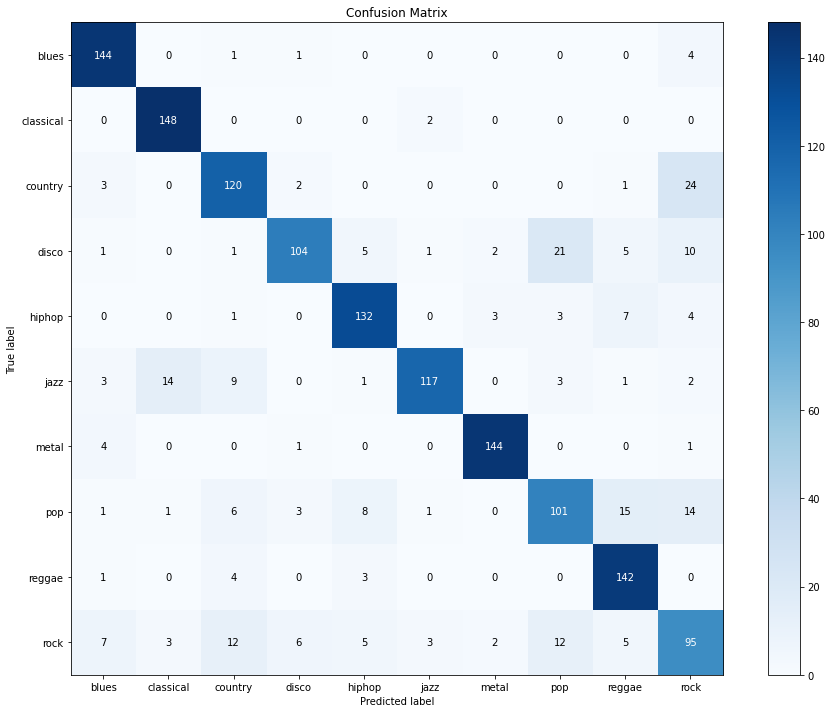


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/25
422/422 - 8s - loss: 1.7700 - accuracy: 0.3977 - val_loss: 3.2972 - val_accuracy: 0.2267 - lr: 0.0010 - 8s/epoch - 19ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/25
422/422 - 7s - loss: 1.1048 - accuracy: 0.6271 - val_loss: 1.0876 - val_accuracy: 0.6373 - lr: 0.0010 - 7s/epoch - 17ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/25
422/422 - 7s - loss: 0.8076 - accuracy: 0.7347 - val_loss: 1.3378 - val_accuracy: 0.5807 - lr: 0.0010 - 7s/epoch - 17ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/25
422/422 - 7s - loss: 0.6171 - accuracy: 0.8038 - val_loss: 0.7891 - val_accuracy: 0.7693 - lr: 0.0010 - 7s/epoch - 17ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 5/25
422/422 - 7s - loss: 0.3497 - accuracy: 0.888

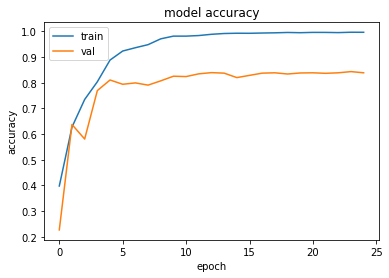

<Figure size 432x288 with 0 Axes>

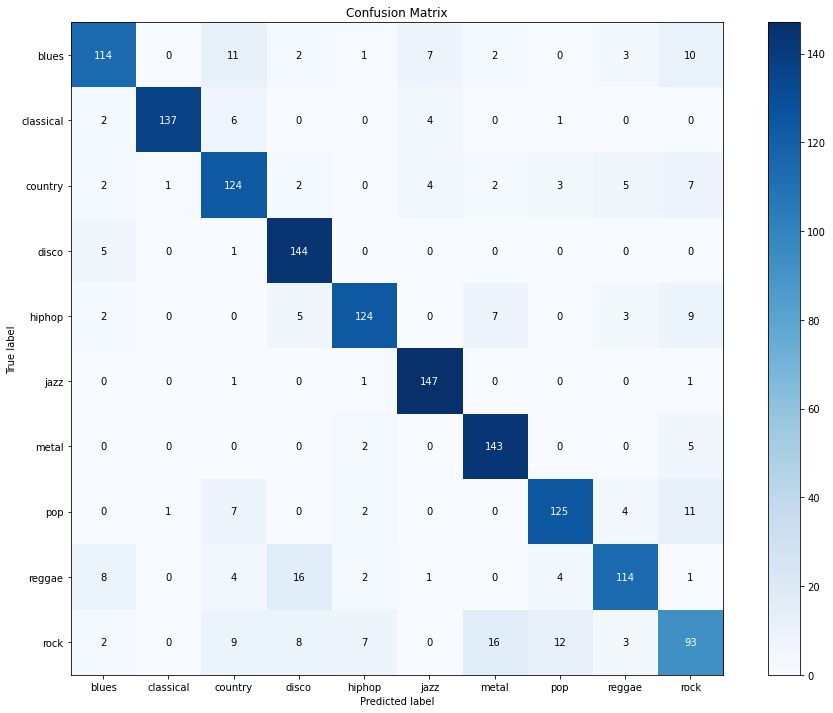

In [ ]:
res_array=test_procedure(5)

In [ ]:
np.mean(res_array)

0.8099999904632569

In [ ]:
res_array

[0.8106666803359985,
 0.8053333163261414,
 0.7960000038146973,
 0.831333339214325,
 0.8433333039283752]

In [ ]:
np.mean(res_array)

0.8173333287239075

In [ ]:
np.std(res_array)

0.017410079002240147

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Binomial statistical test

In [ ]:
res_tab=res_array

In [ ]:
np.mean(res_tab)

0.8173333287239075

In [ ]:
from scipy import stats

In [ ]:
success_num=sum(np.around(np.array(res_tab)*len(valY),decimals=1))
print(success_num)

6130.0


In [ ]:
trials_num=len(valY)*len(res_tab)
print(trials_num)

7500


In [ ]:
stats.binom_test(success_num, n=trials_num, p=0.80, alternative='greater')

7.921317028190341e-05

In [ ]:
stats.binom_test(success_num, n=trials_num, p=0.81, alternative='greater')

0.053802485376629024

# Hyper - parameter tuning with keras-tuner

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 4.9 MB/s 


In [ ]:
import keras_tuner as kt

In [ ]:
def lr_scheduler(epoch, lr):
    decay_step = 4
    if epoch % decay_step == 0 and epoch:
      return lr /2
    return lr

In [ ]:
def model_builder(hp):
  model = models.Sequential()
  hp_filters = hp.Int('filters', min_value=32, max_value=64, step=16)
  model.add(layers.Conv2D(hp_filters, (3,3), activation='relu', input_shape=inp_shape))
  model.add(layers.MaxPooling2D((2,1)))
  model.add(layers.BatchNormalization(axis=-1))
  model.add(layers.Conv2D(hp_filters, (3,3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D(2))
  model.add(layers.BatchNormalization(axis=-1))
  model.add(layers.Conv2D(hp_filters*2, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D(2))
  model.add(layers.BatchNormalization(axis=-1))
  model.add(layers.Conv2D(hp_filters*4, (3,3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D(2))
  model.add(layers.BatchNormalization(axis=-1))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=128, max_value=640, step=128)
  hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
  model.add(layers.Flatten())
  model.add(layers.Dense(hp_units, activation = 'relu'))
  model.add(layers.Dropout(rate=hp_dropout))
  model.add(layers.Dense(hp_units/2, activation = 'relu'))
  model.add(layers.Dropout(rate=hp_dropout))
  model.add(layers.Dense(hp_units/4, activation = 'relu'))
  model.add(layers.Dropout(rate=hp_dropout))
  model.add(layers.Dense(10, activation = 'softmax'))

  # Tune the learning rate for the optimizer

  hp_learning_rate = hp.Choice('learning_rate', values=[0.0002,0.0005,0.001,0.0015])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
def test_procedure_tuner_model(repeats):
  
  epochs_num=25
  res_array=[]
  for i in range (repeats):
    trainX, trainY, valX, valY = split_sets_proc(i+30)
    hypermodel = tuner.hypermodel.build(hyperparameters[ii])
    checkpoint_filepath = '/tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

    LearningRateScheduler(lr_scheduler, verbose=1)
    # stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    history = model.fit(np.array(trainX), np.array(trainY), epochs=epochs_num, 
                        validation_data=(np.array(valX), np.array(valY)),callbacks=[ model_checkpoint_callback, LearningRateScheduler(lr_scheduler, verbose=1)],verbose=2)
    model.load_weights(checkpoint_filepath)
    test_loss, test_acc = model.evaluate(np.array(valX),  np.array(valY), verbose=2)
    res_array.append(test_acc)

    
    plt.figure(i)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    

    plt.figure(i+repeats)
    preds=np.asarray(model.predict(np.array(valX)))
    y_pred_class = np.argmax(preds, axis=1)
    fig, ax = plt.subplots(figsize=(16,12))
    plot_confusion_matrix(le.inverse_transform(np.array(valY)), le.inverse_transform(y_pred_class), ax=ax)
    plt.show()
    
    K.clear_session()
    del model

  return res_array

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     overwrite=True,
                     project_name='intro_to_kt')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(np.array(trainX), np.array(trainY), epochs=20, validation_data=(np.array(valX), np.array(valY)), callbacks=[stop_early,LearningRateScheduler(lr_scheduler, verbose=1)])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')} and the optimal dropout is {best_hps.get('dropout')} and the number of filters is {best_hps.get('filters')}.
""")

Trial 30 Complete [00h 03m 41s]
val_accuracy: 0.7326666712760925

Best val_accuracy So Far: 0.7940000295639038
Total elapsed time: 00h 44m 30s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384 and the optimal learning rate for the optimizer
is 0.0002 and the optimal dropout is 0.30000000000000004 and the number of filters is 48.



In [ ]:
hps = tuner.get_best_hyperparameters(num_trials=30)
for ii in range(0, 30):
  hps_temp = hps[ii]
  print("Trial number", str(ii + 1))
  print(hps_temp.values)

Trial number 1
{'filters': 32, 'units': 512, 'dropout': 0.30000000000000004, 'learning_rate': 0.0005, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Trial number 2
{'filters': 64, 'units': 384, 'dropout': 0.30000000000000004, 'learning_rate': 0.0002, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}
Trial number 3
{'filters': 64, 'units': 512, 'dropout': 0.30000000000000004, 'learning_rate': 0.0001, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0032'}
Trial number 4
{'filters': 64, 'units': 384, 'dropout': 0.4000000000000001, 'learning_rate': 0.0001, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0023'}
Trial number 5
{'filters': 48, 'units': 384, 'dropout': 0.30000000000000004, 'learning_rate': 0.0005, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/roun